In [2]:
DATA = "/../../datasets"

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, CopulaGANSynthesizer
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
import os

os.makedirs("results", exist_ok=True)

In [8]:
def plot_label(df):
    class_counts = df['label'].value_counts()

    # Görselleştirme
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.index, class_counts.values, color='skyblue')
    plt.xlabel("Label Classes")
    plt.ylabel("Count")
    plt.title("Class Distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print(class_counts)


In [5]:
train = pd.read_csv(fr"{DATA}/data/train.csv")

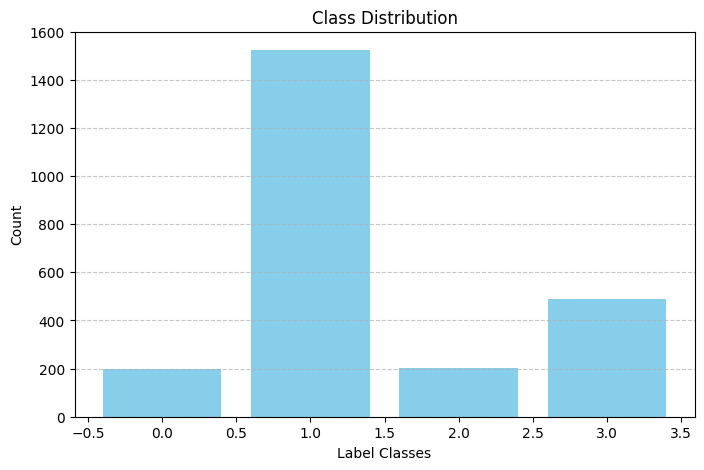

label
1    1524
3     489
2     203
0     198
Name: count, dtype: int64


In [9]:
plot_label(train)

In [10]:
test = pd.read_csv(fr"{DATA}/data/test.csv")

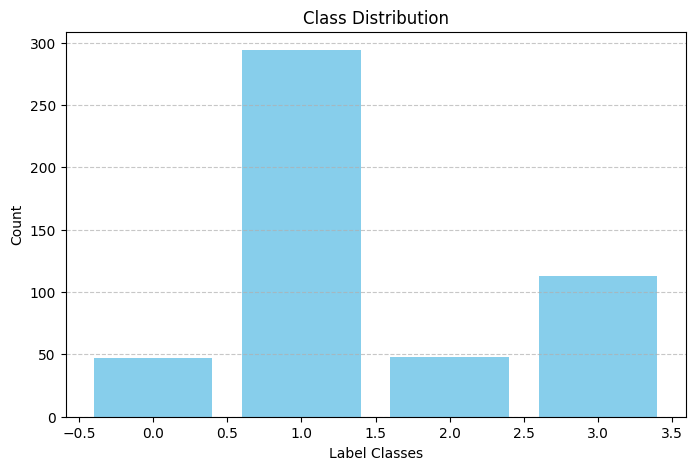

label
1    294
3    113
2     48
0     47
Name: count, dtype: int64


In [11]:
plot_label(test)

In [12]:
TRAIN_COLS = ['lc', 'pi', 'ma', 'nbd', 'ml', 'd', 'mi', 'fo', 'r', 'e']
train = train[TRAIN_COLS + ["label"]]
test = test[TRAIN_COLS + ["label"]]

x_train = train.drop(columns=["label"])
y_train = train["label"]

x_test = test.drop(columns=["label"])
y_test = test["label"]

In [19]:
classifiers = {
    "SVM": LinearSVC(
        penalty="l2",
        loss="squared_hinge",
        dual=True,
        C=0.5,
        class_weight="balanced",
        max_iter=5000,
        tol=1e-4,
        random_state=42
    ),
    "XGBoost": XGBClassifier(objective="multi:softprob",
                             num_class=4,
                             eval_metric="mlogloss",
                             num_parallel_tree=None,
                             n_estimators=200,
                             tree_method="hist",
                             random_state=42, ),
    "PassiveAggressive": PassiveAggressiveClassifier(C=1.0,
                                                     max_iter=1000,
                                                     loss="hinge",
                                                     tol=1e-3,
                                                     random_state=50),
}

In [29]:
from src.evalution import evaluate_result

generators = {
    "GaussianCopula": GaussianCopulaSynthesizer,
    "CTGAN": CTGANSynthesizer,
    #"TVAE": TVAESynthesizer,
    "CopulaGAN": CopulaGANSynthesizer
}

model_name = "PassiveAggressive"
model_selected = classifiers[model_name]

# Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train)
metadata.update_column(column_name='label', sdtype='categorical')

results = []

# Tüm yöntemleri uygula
for name, Synthesizer in generators.items():
    print(f"--- {name} ile veri üretiliyor ---")

    # Sentetik veri üretimi
    try:
        synthesizer = Synthesizer(metadata, epochs=1500)
    except:
        synthesizer = Synthesizer(metadata)
    synthesizer.fit(train)
    synthetic_data = synthesizer.sample(len(train) * 2)

    # Veri görselleştirme
    plt.figure(figsize=(10, 5))
    sns.histplot(train['label'], kde=True, color='blue', label="Real Data", bins=4)
    sns.histplot(synthetic_data['label'], kde=True, color='red', label="Syntetic Data", bins=4)
    plt.legend()
    plt.title("Real vs. Syntetic Data Distribution")
    plt.savefig(f"results/{name}_distribution.png")  # Görseli kaydet
    plt.close()

    # Dengelenmiş veri oluştur
    target_size = train['label'].value_counts().max()
    balanced_data = train.copy()
    for label in train['label'].unique():
        count_needed = target_size - (train['label'] == label).sum()
        if count_needed > 0:
            synth_samples = synthetic_data[synthetic_data['label'] == label].sample(count_needed, replace=True)
            balanced_data = pd.concat([balanced_data, synth_samples])

    balanced_data.to_csv(f"results/{name}_train_augmented_synthetic.csv", index=False)
    # Model eğitimi
    X = balanced_data.drop(columns=['label'])
    y = balanced_data['label']

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(x_test)

    selector = SelectKBest(score_func=f_classif, k=9)
    X_train_selected = selector.fit_transform(X_train_scaled, y)
    X_test_selected = selector.transform(X_test_scaled)

    poly = PolynomialFeatures(degree=3, interaction_only=True)
    X_train_poly = poly.fit_transform(X_train_selected)
    X_test_poly = poly.transform(X_test_selected)

    # Cross-validation (5-Fold)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_poly, y)):
        print(f"Fold {fold + 1}")
        X_train_fold, X_val_fold = X_train_poly[train_idx], X_train_poly[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # XGBoost modeli
        model = model_selected

        model.fit(X_train_fold, y_train_fold)

        # Test setinde tahmin yap
        y_pred = model.predict(X_test_poly)
        eval_result = evaluate_result(test['label'], y_pred, None)
        print(eval_result)

        fold_results.append(eval_result)

    # Ortalama sonuçları hesapla
    avg_results = {metric: np.mean([fold[metric] for fold in fold_results]) for metric in fold_results[0]}
    avg_results["method"] = name
    results.append(avg_results)
    print(avg_results)

# Sonuçları Excel'e kaydet
results_df = pd.DataFrame(results)
results_df.to_excel(f"results/synthetic_data_results_{model_name}.xlsx", index=False)

--- GaussianCopula ile veri üretiliyor ---


/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



Fold 1
{'eval_f1': 0.46214688665228365, 'eval_f1_class1': 0.0, 'eval_f1_class2': 0.6873156342182891, 'eval_f1_class3': 0.0, 'eval_f1_class4': 0.2648401826484018, 'eval_acc': 0.5219123505976095, 'eval_precision': 0.4169436640231527, 'eval_recall': 0.5219123505976095, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.051750259943460136, 'eval_cohen_kappa_score': 0.04807054138617628, 'eval_gmean': 0.5248476002801483}
Fold 2
{'eval_f1': 0.4261754542587732, 'eval_f1_class1': 0.0, 'eval_f1_class2': 0.5953177257525084, 'eval_f1_class3': 0.2222222222222222, 'eval_f1_class4': 0.25, 'eval_acc': 0.4402390438247012, 'eval_precision': 0.41391313009021735, 'eval_recall': 0.4402390438247012, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.019475343648774835, 'eval_cohen_kappa_score': 0.0192653980658124, 'eval_gmean': 0.5017027815608915}
Fold 3
{'eval_f1': 0.47482570977911753, 'eval_f1_class1': 0.12903225806451613, 'eval_f1_class2': 0.6735598227474151, 'eval_f1_class3': 0.2702702702702703, 'eval_f1_class4': 0.18848167539267016, 

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.



Fold 1
{'eval_f1': 0.4268435120997229, 'eval_f1_class1': 0.04938271604938271, 'eval_f1_class2': 0.629570747217806, 'eval_f1_class3': 0.0, 'eval_f1_class4': 0.23770491803278687, 'eval_acc': 0.45617529880478086, 'eval_precision': 0.4014883211893026, 'eval_recall': 0.45617529880478086, 'eval_ROC-UAC': 0.0, 'eval_mcc': -0.00021609009479222396, 'eval_cohen_kappa_score': -0.00021165256865951498, 'eval_gmean': 0.5000867419434037}
Fold 2
{'eval_f1': 0.1348273229032285, 'eval_f1_class1': 0.15841584158415842, 'eval_f1_class2': 0.11042944785276074, 'eval_f1_class3': 0.2465753424657534, 'eval_f1_class4': 0.14102564102564102, 'eval_acc': 0.1593625498007968, 'eval_precision': 0.41089078508487464, 'eval_recall': 0.1593625498007968, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.03736542841823947, 'eval_cohen_kappa_score': 0.025991163096502512, 'eval_gmean': 0.3710643290980523}
Fold 3
{'eval_f1': 0.42020996876942235, 'eval_f1_class1': 0.09032258064516129, 'eval_f1_class2': 0.593103448275862, 'eval_f1_class3': 0.2

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.



Fold 1
{'eval_f1': 0.3021013393461687, 'eval_f1_class1': 0.09411764705882353, 'eval_f1_class2': 0.33004926108374383, 'eval_f1_class3': 0.2803738317757009, 'eval_f1_class4': 0.3251231527093596, 'eval_acc': 0.30278884462151395, 'eval_precision': 0.4352184923630217, 'eval_recall': 0.30278884462151395, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.038044025189309806, 'eval_cohen_kappa_score': 0.031149882271200968, 'eval_gmean': 0.4687499952719454}
Fold 2
{'eval_f1': 0.45371611616047797, 'eval_f1_class1': 0.12121212121212122, 'eval_f1_class2': 0.714859437751004, 'eval_f1_class3': 0.03389830508474576, 'eval_f1_class4': 0.09090909090909091, 'eval_acc': 0.5537848605577689, 'eval_precision': 0.4446759998884023, 'eval_recall': 0.5537848605577689, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.033992678161154095, 'eval_cohen_kappa_score': 0.024346226595172382, 'eval_gmean': 0.5066745407536433}
Fold 3
{'eval_f1': 0.4300590826589891, 'eval_f1_class1': 0.12962962962962962, 'eval_f1_class2': 0.6231647634584013, 'eval_f1_cl

In [24]:

from sdmetrics.reports.single_table import QualityReport

report = QualityReport()

report.generate(train, synthetic_data, metadata.to_dict())
fig = report.get_visualization(property_name='Column Shapes')
fig.show()


Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 11/11 [00:00<00:00, 27.49it/s]|
Column Shapes Score: 76.0%

(2/2) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 128.31it/s]|
Column Pair Trends Score: 85.25%

Overall Score (Average): 80.62%


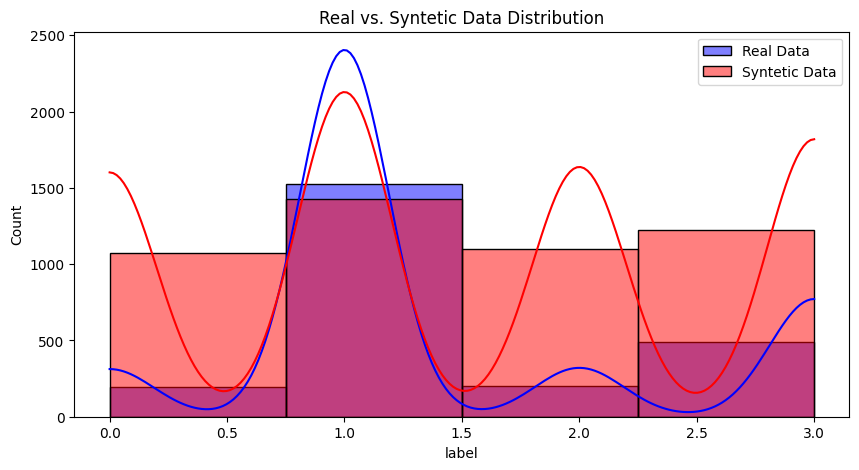

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(train['label'], kde=True, color='blue', label="Real Data", bins=4)
sns.histplot(synthetic_data['label'], kde=True, color='red', label="Syntetic Data", bins=4)
plt.legend()
plt.title("Real vs. Syntetic Data Distribution")
plt.show()
